In [51]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore
from sklearn.metrics import mean_squared_error # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [53]:
df = pd.read_csv('datasets/dataset_PS_2.csv')
df = df.astype({'date': 'datetime64[ns]'})
# df.drop(columns=['irradiation', 'cloudiness', 'holiday', 'precipitation'], inplace=True)
df['shifted_consumption_168'] = df['consumption'].shift(168)
df['shifted_consumption_48'] = df['consumption'].shift(48)
df['hour'] = df['date'].dt.hour
df['weekDay'] = df['date'].dt.weekday

# sort by holidays
df = df.sort_values(by='holiday')

holidays_map = {holiday: i for i, holiday in enumerate(df['holiday'].unique())}
df['holiday'] = df['holiday'].map(holidays_map)

# sort holidays
df = df.sort_values(by='date')

df = df.fillna(df.mean())
df

,date,consumption,temperature,precipitation,irradiation,price,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,hour,weekDay
0,2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,51.44327,37.0,7,1295.358621,1295.144189,1,5
1,2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,55.91396,37.0,7,1295.358621,1295.144189,2,5
2,2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,46.94279,37.0,7,1295.358621,1295.144189,3,5
3,2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.67210,37.0,7,1295.358621,1295.144189,4,5
4,2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,39.70000,37.0,7,1295.358621,1295.144189,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
24615,2024-10-23 19:00:00,1583.0,14.4,0.0,0.0,191.94000,97.0,0,1627.000000,1563.000000,19,2
24616,2024-10-23 20:00:00,1523.0,13.4,0.5,0.0,132.71000,97.0,0,1601.000000,1527.000000,20,2
24617,2024-10-23 21:00:00,1428.0,12.9,0.8,0.0,106.98000,97.0,0,1452.000000,1409.000000,21,2
24618,2024-10-23 22:00:00,1308.0,12.6,1.3,0.0,103.02000,97.0,0,1330.000000,1287.000000,22,2


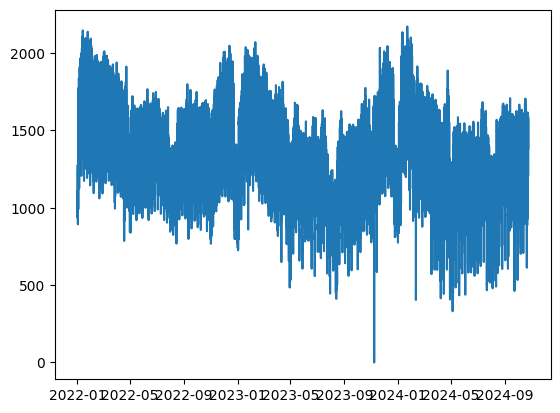

In [54]:
plt.plot(df['date'], df['consumption'])

In [55]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore
from sklearn.metrics import mean_absolute_percentage_error # type: ignore

df_hourly = df.copy()
df_hourly['shifted_consumption_168'] = df_hourly['consumption'].shift(168)
df_hourly['shifted_consumption_48'] = df_hourly['consumption'].shift(48)
df_hourly['hour'] = df_hourly['date'].dt.hour
df_hourly['weekDay'] = df_hourly['date'].dt.weekday

# Split the dataset based on the cutoff date
cutoff_date = '2024-10-17 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]

In [56]:
#for 1 week
date = df_hourly[df_hourly['date'] >= cutoff_date].iloc[:, 0:1].astype('datetime64[ns]')

# for 1 day
# test_data = df_hourly[df_hourly['date'] >= cutoff_date].head(24)
# date = df_hourly[df_hourly['date'] >= cutoff_date].iloc[:, 0:1].astype('datetime64[ns]').head(24)

date.head()

,date
24452,2024-10-17 00:00:00
24453,2024-10-17 01:00:00
24454,2024-10-17 02:00:00
24455,2024-10-17 03:00:00
24456,2024-10-17 04:00:00


In [70]:
X_train = train_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48', 'temperature', 'holiday', 'cloudiness', 'precipitation', 'irradiation', 'price']]
X_test = test_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48', 'temperature', 'holiday', 'cloudiness', 'precipitation', 'irradiation', 'price']]
y_train = train_data['consumption']
y_test = test_data['consumption']

reg = GradientBoostingRegressor(random_state=0,
								learning_rate=0.1,
								n_estimators=200,
								max_depth=5, 
								min_samples_split=10
								)
reg.fit(X_train, y_train)
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='consumption')

In [71]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error # type: ignore
from sktime.performance_metrics.forecasting import mean_squared_percentage_error # type: ignore

mse = root_mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
mape = mean_absolute_percentage_error(y_test, forecast)
rmspe = mean_squared_percentage_error(y_test, forecast, square_root=True)

plt_title = 'MAE: {0:.2f}, RMSE: {1:.2f}, MAPE: {2:.2f}, RMSPE: {3:.2f}'.format(mae, mse, mape*100, rmspe*100)

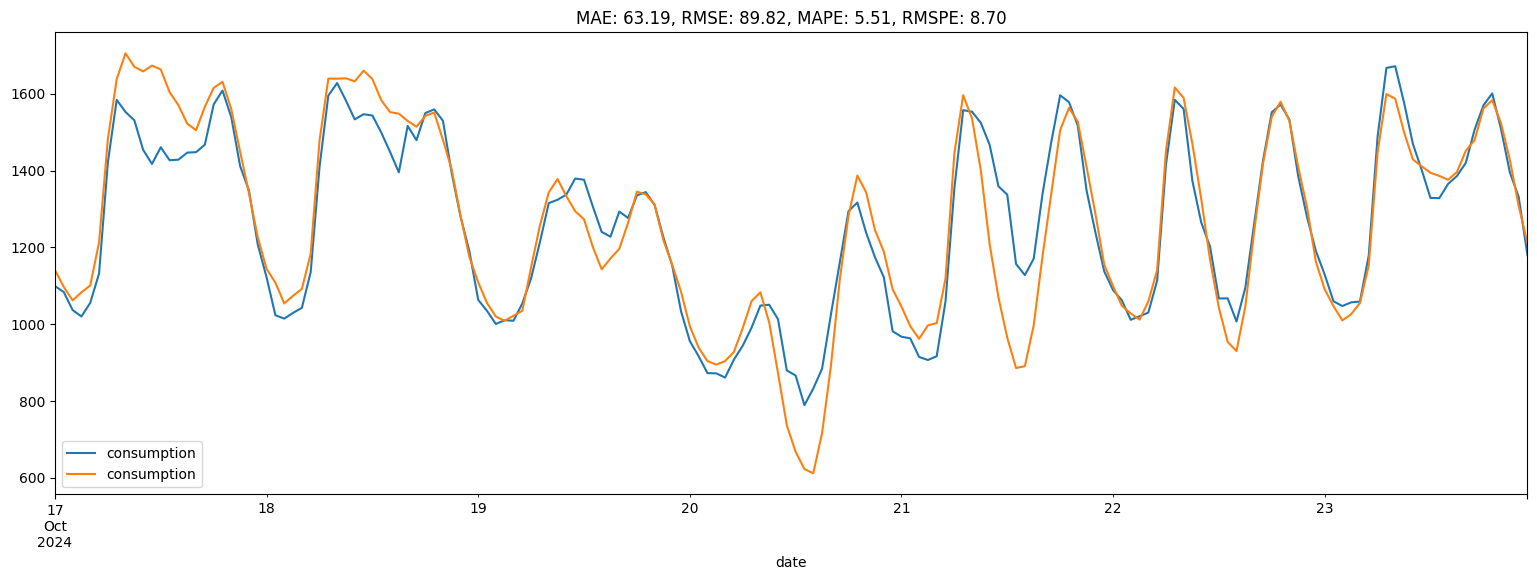

In [72]:
forecast.index = date['date']
y_test.index = date['date']
forecast.plot(title=plt_title,figsize=(19, 6),legend=True)
ax = y_test.plot(title=plt_title,figsize=(19, 6), legend=True, x=date['date'])
# add date to plot as x axis

In [48]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Define the GBR model
gbr = GradientBoostingRegressor()

# Perform grid search
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
print("Best model:", best_model)

# Evaluate the best model
forecast = best_model.predict(X_test)
mse = root_mean_squared_error(y_test, forecast)
print("RMSE:", mse)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

```
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best model: GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=200)
RMSE: 103.08038690634775
```

In [73]:
forecast.to_csv('forecasts/forecast_GBR_wHolidays_wPrices.csv')